## 训练 mmdetection和mmpose

### 1. 环境配置

In [39]:

# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/home/hanhan/anaconda3/envs/mmpose/bin/python


In [40]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu111

torch version: 1.10.0+cu111 True
torchvision version: 0.11.0+cu111
mmpose version: 1.0.0
cuda version: 11.1
compiler information: GCC 7.3


In [42]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.10.0+cu111 True
torchvision version: 0.11.0+cu111
mmpose version: 1.0.0
cuda version: 11.1
compiler information: GCC 7.3


In [72]:
# from google.colab.patches import cv2_imshow

### 2. 验证安装成功

In [79]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False



img = 'tests/data/coco/000000197388.jpg'
pose_config = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

device = 'cpu'
cfg_options = dict(model=dict(test_cfg=dict(output_heatmaps=True)))


# build detector
detector = init_detector(det_config, det_checkpoint, device=device)

# build pose estimator
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint,
    device=device, cfg_options=cfg_options)

# init visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.line_width = 1

visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(pose_estimator.dataset_meta)


# !bash train.sh

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmpose.visualization.local_visualizer.PoseLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [64]:
def visualize_img(img_path, detector, pose_estimator, visualizer,
                  show_interval, out_file):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    init_default_scope(detector.cfg.get('default_scope', 'mmdet'))
    detect_result = inference_detector(detector, img_path)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img_path, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    img = mmcv.imread(img_path, channel_order='rgb')

    visualizer.add_datasample(
        'result',
        img,
        data_sample=data_samples,
        draw_gt=False,
        draw_heatmap=True,
        draw_bbox=True,
        show=False,
        wait_time=show_interval,
        out_file=out_file,
        kpt_thr=0.3)

In [65]:

visualize_img(
    img,
    detector,
    pose_estimator,
    visualizer,
    show_interval=0,
    out_file=None)

vis_result = visualizer.get_image()
     

### 3. mmdetection

#### 3.1 训练

In [80]:
# !bash train.sh

#### 3.1 mmdetection test验证

In [31]:
!python /home/hanhan/cc_wrod/develop/mmlab/mmdetection/tools/test.py /home/hanhan/cc_wrod/develop/mmlab/mmpose/MMPosehomework/configs/rtmdet_tiny_ear.py \
                      ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth

06/10 19:38:17 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 416829850
    GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.4, V11.4.48
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.10.0+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=co

#### 3.3 mmdetection 验证单张图片

In [29]:
!python /home/hanhan/cc_wrod/develop/mmlab/mmdetection/demo/image_demo.py \
        ./MMPosehomework/test/mmexport.jpg \
        /home/hanhan/cc_wrod/develop/mmlab/mmpose/MMPosehomework/configs/rtmdet_tiny_ear.py \
        --weights  ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth \
        --out-dir outputs/ \
        --device cuda:0 \
        --pred-score-thr 0.5

Loads checkpoint by local backend from path: ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth
06/10 19:36:59 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
06/10 19:36:59 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/torch/functional.━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required
to pass the indexing argument. (Triggered internally at  
../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
r

In [34]:
import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope
import numpy as np

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False

local_runtime = False

device = 'cpu'

Loads checkpoint by local backend from path: ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth
06/10 19:58:29 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


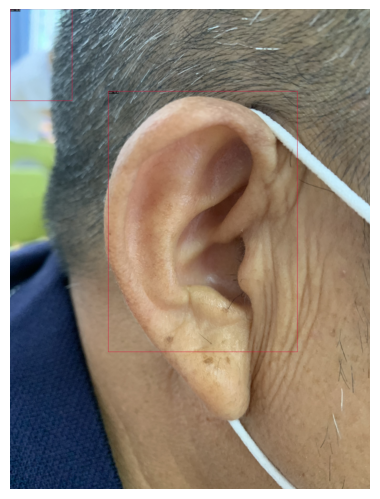

In [35]:

rtmdet = init_detector(
    config='./MMPosehomework/configs/rtmdet_tiny_ear.py',
    checkpoint='./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth',
    device=device)


from mmdet.registry import VISUALIZERS
# init visualizer(run the block only once in jupyter notebook) 
visualizer = VISUALIZERS.build(rtmdet.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = rtmdet.dataset_meta # 注意修改为本模型的数据集信息

image = mmcv.imread('./MMPosehomework/test/mmexport.jpg', channel_order='rgb')
det_result = inference_detector(rtmdet, image)
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=det_result,
    draw_gt = None,
    wait_time=0,
)
visualizer.show()

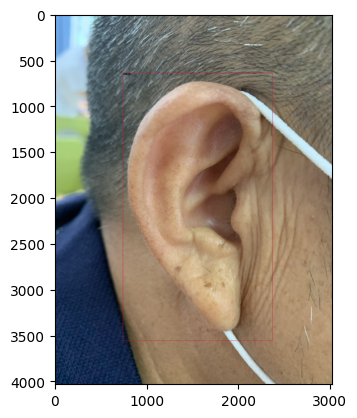

In [78]:
import cv2
import matplotlib.pyplot as plt

img=cv2.imread('outputs/vis/mmexport.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.show()


### 4. mmpose

#### 4.1 mmpose 训练

In [81]:
# !bash train.sh


#### 4.2 mmpose test

In [7]:
!python ./tools/test.py /home/hanhan/cc_wrod/develop/mmlab/mmpose/MMPosehomework/configs/rtmpose_s_ear.py \
                      ./work_dirs/rtmdet_tiny_ear/best_280.pth

Traceback (most recent call last):
  File "/home/hanhan/cc_wrod/develop/mmlab/mmpose/tools/test.py", line 129, in <module>
    main()
  File "/home/hanhan/cc_wrod/develop/mmlab/mmpose/tools/test.py", line 94, in main
    cfg = Config.fromfile(args.config)
  File "/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/mmengine/config/config.py", line 178, in fromfile
    cfg_dict, cfg_text, env_variables = Config._file2dict(
  File "/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/mmengine/config/config.py", line 458, in _file2dict
    check_file_exist(filename)
  File "/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/mmengine/utils/path.py", line 23, in check_file_exist
    raise FileNotFoundError(msg_tmpl.format(filename))
FileNotFoundError: file "/home/hanhan/cc_wrod/develop/mmlab/mmpose/MMPosehomework/configs/rtmpose_s_ear.py" does not exist


#### 4.3 mmpose验证单张图片

In [4]:
!python demo/topdown_demo_with_mmdet.py \
        ./MMPosehomework/configs/rtmdet_tiny_ear.py \
        ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth \
        ./MMPosehomework/configs/rtmpose-s-ear.py \
        ./work_dirs/rtmpose-s-ear/best_PCK_epoch_280.pth \
        --input ./MMPosehomework/test/test01.jpg \
        --output-root outputs \
        --device cuda:0 \
        --bbox-thr 0.5 \
        --kpt-thr 0.5 \
        --nms-thr 0.5 \
        --radius 8 \
        --thickness 4 \
        --draw-bbox \
        --draw-heatmap \
        --show-kpt-idx

Loads checkpoint by local backend from path: ./work_dirs/rtmdet_tiny_ear/best_coco_bbox_mAP_epoch_179.pth
Loads checkpoint by local backend from path: ./work_dirs/rtmpose-s-ear/best_PCK_epoch_280.pth
06/11 14:42:39 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/hanhan/cc_wrod/develop/mmlab/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


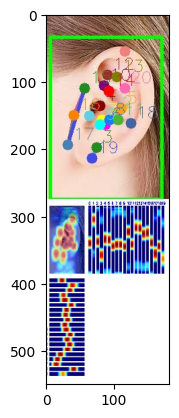

In [6]:
import cv2
import matplotlib.pyplot as plt

img=cv2.imread('outputs/test01.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.show()